## Idea:
How accurately can we measure the position from the Larkin Transformed images?

Using a Gaussian or an Airy Disk gave weird errors that varied with jitter. Kieran explained that they were due to a first-order approximation error. Using the proper function (J1(a * r)/r) fixed the problem.

## Result:
With jitter only, it was accurate to 1200 ppm.

With simulated images using the analytic airy disk function instead of the Toliman pupil I get the same result.

I tried squaring the larkin transformed image and fitting again and it gave much better results. With jitter only it was accurate to 417ppm.

## Effects of Wavefront Error:
With no WFE, noise stddev is 1200 ppm. \
With 1nm RMS WFE, noise stddev is 1260 ppm. \
With 5nm RMS WFE, noise stddev is 1295 ppm. \
With 10nm RMS WFE, noise stddev is 1682 ppm. \
With 20nm RMS WFE, noise stddev is 2986 ppm. \
With 50nm RMS WFE, noise stddev is 7843 ppm. \
With 100nm RMS WFE, noise stddev is 17560 ppm.\


## Effects of Wavefront error on LT(im)**2:
With no WFE, noise stddev is 417 ppm. \
With 1nm RMS WFE, noise stddev is 458 ppm. \
With 5nm RMS WFE, noise stddev is 703 ppm. \
With 10nm RMS WFE, noise stddev is 1207 ppm. \
With 20nm RMS WFE, noise stddev is 2390 ppm. \
With 50nm RMS WFE, noise stddev is 6650 ppm. \
With 100nm RMS WFE, noise stddev is 15559 ppm.

## Effects of individual WFE terms on Autocorrelation:
Tried using same WFE as the 100nm RMS WFE sim above, but using one term only.\
With defocus only (38nm RMS WFE), noise stddev is 1960ppm. First few frames contribute almost all of the scatter, 1255ppm otherwise. \
With astigmatism only (58nm RMS WFE), noise stddev is 8190ppm. First few frames contribute almost all of the scatter, 3786ppm otherwise.\
With coma only (42nm RMS WFE), noise stddev is 10814ppm. 


## Effects of photon noise on Larkin Transform:
1e2 photons peak: 34756 ppm.\
1e3 photons peak: 10825 ppm.\
1e4 photons peak: 3676 ppm.\
1e5 photons peak: 1345 ppm.\

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys

sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/lib/')
import photometry
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/COIN/signal_extraction/')

from modelling_functions import larkin_model,larkin_transform_fit


In [2]:
sim_name = '../sims/jitter_only/'
# sim_name = '../sims/100nm_wfe_with_jitter/'
# sim_name = '../sims/astig_and_jitter/'
# sim_name = '../sims/toliman_100k_photons/'
# sim_name = '../sims/linear_jitter_vert/'
# sim_name = '../no_rotation_1e5signal/'
model_PSF = np.load('../signal_extraction/shift_invariance_data/model_psf.npy')

# sim_name = '../sims/airydisk/'
# model_PSF = np.load(sim_name+'model_psf.npy')

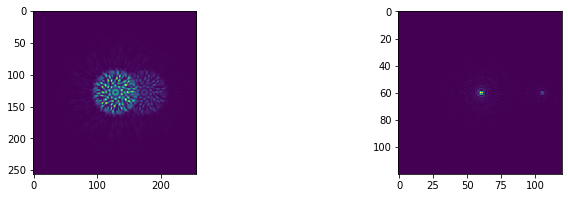

In [3]:
im = np.load(sim_name+'images/{0}.npy'.format(10))

transformed_im = photometry.larkin_transform(model_PSF,im)

sz = 60
transformed_im = transformed_im[128-sz:128+sz,128-sz:128+sz]


plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(im)
# plt.imshow(model_PSF)

plt.subplot(122)
plt.imshow(transformed_im)

# import astropy.io.fits as pf
# pf.writeto('decoded.fits',transformed_im,overwrite=True)
# plt.show()


[ 1.10067119  0.33941194 -0.01646404  2.10300148]
[ 6.57129395e-02  4.53043163e+01 -1.09542923e-02  2.11463593e+00]
(<AiryDisk2D(amplitude=1.10067119, x_0=0.33941194, y_0=-0.01646404, radius=2.10300148)>, <AiryDisk2D(amplitude=0.06571294, x_0=45.30431627, y_0=-0.01095429, radius=2.11463593)>)


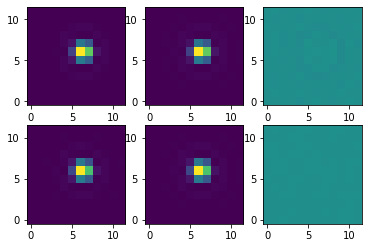

In [4]:
transformed_im = photometry.larkin_transform(model_PSF,im)
transformed_im /= np.max(transformed_im)
# x0,y0,flux0,width0,sep,pa,flux1,width1 = params
params = [0,0,1.2,2.1,44.97,0.,0.25,3.04] # for airy disk
transformed_im = transformed_im**2
f = larkin_transform_fit(params,transformed_im,plot=True,fit_airy=True)
# model = transformed_model(params,transformed_im.shape)
print(f)
# plt.figure(figsize=(15,6))
# plt.subplot(121)
# plt.imshow(model);plt.colorbar()
# plt.subplot(122)
# plt.imshow(transformed_im-model);plt.colorbar()

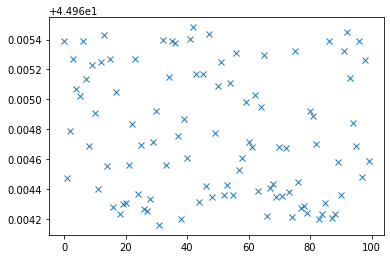

In [5]:
# Loop over some images
from IPython.display import clear_output
params = []
seps = []
xs = np.zeros((100,2))
ys = np.zeros((100,2))
for ix in range(100):
    im = np.load(sim_name+"images/{}.npy".format(ix))
    
    # Transform
#     transformed_im = im/np.max(im)
    transformed_im = photometry.larkin_transform(model_PSF,im)
    transformed_im = transformed_im**2 # Square it!
    transformed_im /= np.max(transformed_im)
    
    # Fit
#     x0 = [0-offset[0],0-offset[1],1.,2.5,45.5,0.,0.2,2.5]
#     x0 = [0,0,1.2,2.5,45.1,0.,0.25,2.5] # for sqrt(airy disk)
    x0 = [0,0,1.2,2.5,45.1,0.,0.25,3.] # for airy disk
    prim_fit,sec_fit = larkin_transform_fit(x0,transformed_im,plot=False,fit_airy=True)
    
    sep = np.sqrt((prim_fit.x_0-sec_fit.x_0)**2 + (prim_fit.y_0-sec_fit.y_0)**2)
    
    xs[ix,0] = prim_fit.x_0.value
    xs[ix,1] = sec_fit.x_0.value
    ys[ix,0] = prim_fit.y_0.value
    ys[ix,1] = sec_fit.y_0.value
    
#     sep = np.sqrt((fit.x_mean_1-fit.x_mean_0)**2 + (fit.y_mean_0-fit.y_mean_1)**2)
#     pa = np.arctan2(fit.x_mean_1-fit.x_mean_0,fit.y_mean_0-fit.y_mean_1) # probably wrong
#     fit.x = [fit.x_mean_0,fit.y_mean_0,fit.amplitude_0,fit.x_stddev_0,
#             sep,pa,fit.amplitude_1,fit.x_stddev_1]

    seps.append(sep)
#     params.append(fit.x)
#     seps.append(fit.x[4])
    
    clear_output(wait=True)
    plt.plot(seps,'x')
    plt.show()

params = np.array(params)
seps = np.array(seps)

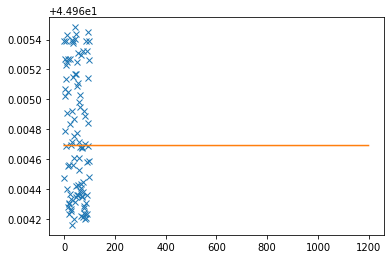

In [6]:
signal = np.loadtxt(sim_name+'signal.csv',skiprows=1,delimiter=',')
plt.clf()
# plt.figure(figsize=(12,3))
# plt.subplot(131)
# plt.plot(xs,'x')

# plt.subplot(132)
# plt.plot(ys,'x')

# plt.subplot(133)
plt.plot(seps,'x')
plt.plot(signal[:,1]+np.median(seps))
# plt.plot(signal[:,1])

(-0.006057232436329055, 0.12756102142333378)

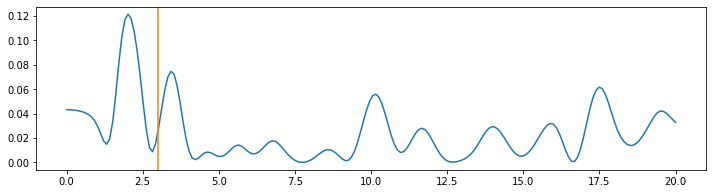

In [7]:
# Plot frequencies
from astropy.timeseries import LombScargle
frequency = np.linspace(0.01, 20., len(seps)*2)
t = np.arange(seps.shape[0])/seps.shape[0]
plt.figure(figsize=(12,3))
power = LombScargle(t, seps).power(frequency)
plt.plot(frequency,power)
yl = plt.ylim()
plt.plot([3.,3.],yl,'-')
plt.ylim(yl)

In [8]:
# print('X,Y scatter in ppm:',np.std(seps)*1e6,np.std(ys)*1e6)
print('Sep accuracy in ppm:',np.std(seps-signal[0:len(seps),1])*1e6)
# print('Sep accuracy in ppm:',np.std((seps-signal[:len(seps),1])[20:]*1e6))
print(sim_name)

Sep accuracy in ppm: 416.91608916972086
../sims/jitter_only/
